## After wrangling and exploring the data in previous notebooks, this notebook will explore feature engineering and then forecasting the total electricity load using regression, time series forecasting, and ensemble methods.

In [1]:
#import standard packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

#import preprocessing/modeling/error metric packages
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import make_column_transformer
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.neighbors import KNeighborsRegressor

In [2]:
combined_avg = pd.read_csv('combined_avg.csv', index_col='time', parse_dates=True)

In [3]:
combined_avg.head(2)

,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,generation other,...,price day ahead,price actual,temp,pressure,humidity,wind_speed,rain_1h,snow_3h,clouds_all,city
time,,,,,,,,,,,,,,,,,,,,,
2014-12-31 23:00:00+00:00,447.0,329.0,4844.0,4821.0,162.0,863.0,1051.0,1899.0,7096.0,43.0,...,50.1,65.41,272.491463,1016.4,82.4,2.0,0.0,0.0,0.0,Kolkata
2015-01-01 00:00:00+00:00,449.0,328.0,5196.0,4755.0,158.0,920.0,1009.0,1658.0,7096.0,43.0,...,48.1,64.92,272.512700,1016.2,82.4,2.0,0.0,0.0,0.0,Greater Hyderabad


In [4]:
combined_avg.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 35064 entries, 2014-12-31 23:00:00+00:00 to 2018-12-31 22:00:00+00:00
Data columns (total 28 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   generation biomass                           35064 non-null  float64
 1   generation fossil brown coal/lignite         35064 non-null  float64
 2   generation fossil gas                        35064 non-null  float64
 3   generation fossil hard coal                  35064 non-null  float64
 4   generation fossil oil                        35064 non-null  float64
 5   generation hydro pumped storage consumption  35064 non-null  float64
 6   generation hydro run-of-river and poundage   35064 non-null  float64
 7   generation hydro water reservoir             35064 non-null  float64
 8   generation nuclear                           35064 non-null  float64
 9   generation other         

In [5]:
#function to make train-test split for time-indexed data
def ts_train_test(data, target_col_name = 'total load actual', test_size=0.15, stdzd=False, cols_to_scale=None):
    df = data.copy()
    test_index = int(len(df)*(1-test_size)) #get index where test set begins
        
    X_train = df.drop([target_col_name], axis = 1).iloc[:test_index]
    y_train = df[target_col_name].iloc[:test_index]
    X_test = df.drop([target_col_name], axis = 1).iloc[test_index:]
    y_test = df[target_col_name].iloc[test_index:]
    
    # StandardScaler fit seperately on training and test sets
    if stdzd == True:
        scaler = StandardScaler()
        X_train[cols_to_scale] = scaler.fit_transform(X_train[cols_to_scale])
        X_test[cols_to_scale] = scaler.transform(X_test[cols_to_scale])
    
    return X_train, X_test, y_train, y_test        

In [6]:
#Let's engineer some categorical features for use in a regression model like weekend/weekday, winter/summer/spring-fall
df_features = combined_avg.iloc[:,16:].drop(['price day ahead', 'price actual','total load forecast'], axis=1)
features_min = df_features.copy()
df_features.head()

,total load actual,temp,pressure,humidity,wind_speed,rain_1h,snow_3h,clouds_all,city
time,,,,,,,,,
2014-12-31 23:00:00+00:00,25385.0,272.491463,1016.4,82.4,2.0,0.0,0.0,0.0,Kolkata
2015-01-01 00:00:00+00:00,24382.0,272.512700,1016.2,82.4,2.0,0.0,0.0,0.0,Greater Hyderabad
2015-01-01 01:00:00+00:00,22734.0,272.099137,1016.8,82.0,2.4,0.0,0.0,0.0,Mumbai
2015-01-01 02:00:00+00:00,21286.0,272.089469,1016.6,82.0,2.4,0.0,0.0,0.0,Kolkata
2015-01-01 03:00:00+00:00,20264.0,272.145900,1016.6,82.0,2.4,0.0,0.0,0.0,Kolkata


In [7]:
#function to calculate basic season label based on month
def season_determination(month):
    if month in [6,7,8,9]: #June-Sept = summer (highest need for cooling in Spain)
        return "summer"
    elif month in [1,2,12]: #Dec, Jan, Feb = winter (highest need for heating)
        return "winter"
    else:
        return "spring/fall" #all other months are spring or fall (similar lower needs for heating/cooling)

In [8]:
day_of_week = {0:'Monday', 1:'Tuesday', 2:'Wednesday', 3: 'Thursday', 4: 'Friday', 5:'Saturday', 6:'Sunday'}
df_features['hour'] = df_features.index.hour
df_features['weekday'] = df_features.index.weekday.map(day_of_week)
df_features['month'] = df_features.index.month #have to create month column because cannot apply() on datetimeindex
df_features['season'] = df_features.month.apply(season_determination)
df_features['nonwork-work_day'] = np.where(df_features.index.weekday > 5, 0, 1)
display(df_features.shape, df_features.head());

(35064, 14)

,total load actual,temp,pressure,humidity,wind_speed,rain_1h,snow_3h,clouds_all,city,hour,weekday,month,season,nonwork-work_day
time,,,,,,,,,,,,,,
2014-12-31 23:00:00+00:00,25385.0,272.491463,1016.4,82.4,2.0,0.0,0.0,0.0,Kolkata,23,Wednesday,12,winter,1
2015-01-01 00:00:00+00:00,24382.0,272.512700,1016.2,82.4,2.0,0.0,0.0,0.0,Greater Hyderabad,0,Thursday,1,winter,1
2015-01-01 01:00:00+00:00,22734.0,272.099137,1016.8,82.0,2.4,0.0,0.0,0.0,Mumbai,1,Thursday,1,winter,1
2015-01-01 02:00:00+00:00,21286.0,272.089469,1016.6,82.0,2.4,0.0,0.0,0.0,Kolkata,2,Thursday,1,winter,1
2015-01-01 03:00:00+00:00,20264.0,272.145900,1016.6,82.0,2.4,0.0,0.0,0.0,Kolkata,3,Thursday,1,winter,1


In [9]:
df_features.drop("month", axis=1, inplace=True)

Now that I've used the weekday and month to create the type_of_day and season columns, 
I need to drop the month column because the test set may not contain all months. Now time to one-hot encode the new categorical variables.

In [10]:
#let's split data and then encode the new catergorical variables
X_train, X_test, y_train, y_test = ts_train_test(data = df_features, stdzd=True, 
                                                 cols_to_scale=['temp','pressure','humidity',
                                                                'wind_speed','rain_1h','snow_3h','clouds_all'])
cat_cols = ['hour','weekday','season','city']
X_train_cat = X_train[['hour','weekday','season','city']]
X_test_cat = X_test[['hour','weekday','season','city']]

encoder = OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore')

encoder.fit(X_train_cat)
X_train.drop(columns = cat_cols, inplace=True)
X_train_cat = pd.DataFrame(encoder.transform(X_train_cat), index=X_train.index, 
                           columns = encoder.get_feature_names_out()).astype(int)
X_train = X_train.join(X_train_cat, how ='outer')
#X_train.head()
encoder.fit(X_test_cat)
X_test.drop(columns = cat_cols, inplace=True)
X_test_cat = pd.DataFrame(encoder.transform(X_test_cat), index = X_test.index, 
                           columns = encoder.get_feature_names_out()).astype(int)
X_test = X_test.join(X_test_cat, how ='outer')

display(X_train.head(3), X_test.head(3), X_train.columns)

,temp,pressure,humidity,wind_speed,rain_1h,snow_3h,clouds_all,nonwork-work_day,hour_1,hour_2,...,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday,season_summer,season_winter,city_Kolkata,city_Mumbai,city_NCR
time,,,,,,,,,,,,,,,,,,,,,
2014-12-31 23:00:00+00:00,-2.327401,0.038628,0.980456,-0.349236,-0.369491,-0.052006,-1.423223,1,0,0,...,0,0,0,0,1,0,1,1,0,0
2015-01-01 00:00:00+00:00,-2.324453,0.015395,0.980456,-0.349236,-0.369491,-0.052006,-1.423223,1,0,0,...,0,0,1,0,0,0,1,0,0,0
2015-01-01 01:00:00+00:00,-2.381861,0.085093,0.953265,-0.064045,-0.369491,-0.052006,-1.423223,1,1,0,...,0,0,1,0,0,0,1,0,1,0


,temp,pressure,humidity,wind_speed,rain_1h,snow_3h,clouds_all,nonwork-work_day,hour_1,hour_2,...,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday,season_summer,season_winter,city_Kolkata,city_Mumbai,city_NCR
time,,,,,,,,,,,,,,,,,,,,,
2018-05-26 19:00:00+00:00,0.656574,-0.333094,-0.243123,-0.064045,-0.369491,-0.052006,-0.265015,1,0,0,...,1,0,0,0,0,0,0,0,0,0
2018-05-26 20:00:00+00:00,0.456407,-0.309861,0.341476,-0.349236,-0.369491,-0.052006,-0.589313,1,0,0,...,1,0,0,0,0,0,0,0,0,1
2018-05-26 21:00:00+00:00,0.295386,-0.263396,0.626978,-0.919619,-0.369491,-0.052006,-0.728298,1,0,0,...,1,0,0,0,0,0,0,0,0,1


Index(['temp', 'pressure', 'humidity', 'wind_speed', 'rain_1h', 'snow_3h',
       'clouds_all', 'nonwork-work_day', 'hour_1', 'hour_2', 'hour_3',
       'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10',
       'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15', 'hour_16',
       'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_22',
       'hour_23', 'weekday_Monday', 'weekday_Saturday', 'weekday_Sunday',
       'weekday_Thursday', 'weekday_Tuesday', 'weekday_Wednesday',
       'season_summer', 'season_winter', 'city_Kolkata', 'city_Mumbai',
       'city_NCR'],
      dtype='object')

So now X is split into train and test sets, with the first 85% of the data going to training to try to predict approximately the last 7 months out of the four years of data.

# Modeling

First I have written a couple helper functions for calculating error metrics and for creating a TS plot comparing predicted vs actual load for the various forecasting models I will try out.

### Helper functions

In [11]:
#function for calculating and presenting error metrics, and storing in a dict for comparison at the end
error_dict = {} #dict to hold model name and error metrics for various models that are investigated

def error_metrics(y_true, y_pred, model_name = None):
    
    #function will print RMSE, R2, MAE, MAPE. Assumes y_pred is np array
    
    RMSE = np.sqrt(mean_squared_error(y_true, y_pred))
    R2 = r2_score(y_true, y_pred)
    MAE = mean_absolute_error(y_true, y_pred)
    MAPE = (np.mean(np.abs((y_true - y_pred) / y_true)) * 100)

    print('\nError metrics for model: {}'.format(model_name))
    print("RMSE: %.2f" % RMSE)
    print('Variance/R^2: %.2f' % R2)
    print('MAE: %.2f' % MAE)
    print('Mean Absolute Percentage Error: %.2f %%' % MAPE)
    
    key = ['Model Name','RMSE', 'R2', 'MAE', 'MAPE']
    value = [model_name, RMSE, R2, MAE, MAPE]
    pair = list(zip(key, value))
    '''
    for error in pair:
        error_dict[error[0]]= [error[1]]
    '''
    for error in pair:
        if error[0] in error_dict:
            error_dict[error[0]].append(error[1])
        else:
            error_dict[error[0]]= [error[1]]
            

In [12]:
#function for plotting time series of predicted vs true values
def plot_ts_pred_true(y_pred, y_true, model_name=None):
    fig, ax = plt.subplots(figsize =(15,10))
    ax.plot(y_true.index, y_pred, linestyle='-', linewidth=1, label = 'Model Forecasted Total Load', color = 'blue',alpha = 0.4)
    y_true.plot(linestyle='-', linewidth=1, label = 'Actual Total Load', color = 'red',alpha = 0.4)

    plt.ylabel('Load/Demand (MW)')
    plt.xlabel("Time")
    plt.title("Observed vs model-predicted total load (MWH) using {}".format(model_name))
    plt.legend()
    plt.show()

First I will try out a simple linear regression using the weather and categorical variables:
### Linear Regression

In [13]:
#instantiate and fit linear regression model
linreg = LinearRegression()
linreg.fit(X_train, y_train)

LinearRegression()

In [14]:
#calculate error metrics for train set
error_metrics(linreg.predict(X_train), y_train, model_name = 'simple linear regression (train)')


Error metrics for model: simple linear regression (train)
RMSE: 2860.88
Variance/R^2: 0.36
MAE: 2202.80
Mean Absolute Percentage Error: 7.64 %


In [15]:
#calculate error metrics for test set
error_metrics(linreg.predict(X_test), y_test, model_name = 'simple linear regression (test)')


Error metrics for model: simple linear regression (test)
RMSE: 2850.09
Variance/R^2: 0.36
MAE: 2174.62
Mean Absolute Percentage Error: 7.55 %


c:\Users\jamua\AppData\Local\Programs\Python\Python313\Lib\site-packages\pandas\plotting\_matplotlib\core.py:981: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  return ax.plot(*args, **kwds)


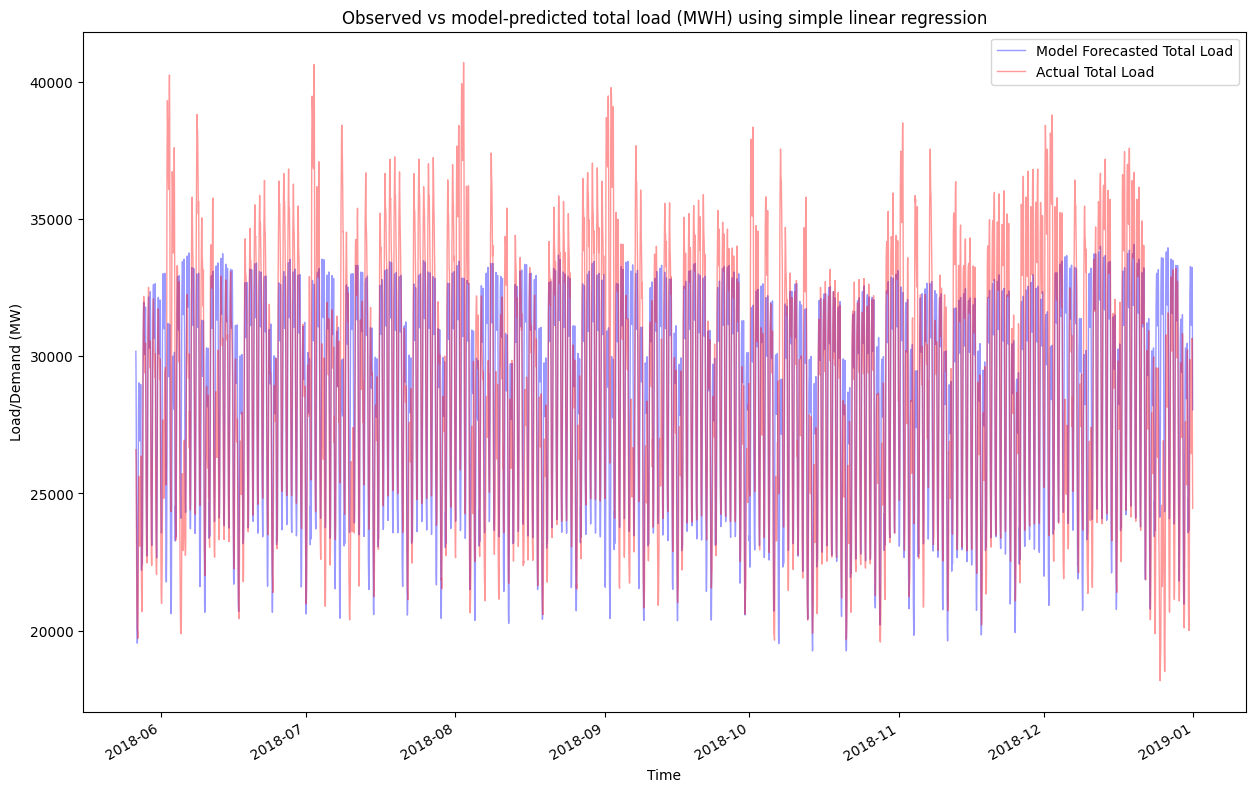

In [16]:
plot_ts_pred_true(y_pred = linreg.predict(X_test), y_true = y_test, model_name = "simple linear regression")

In [17]:
#let's try using a df with reduced feature space, by eliminating some possibly extraneous variables:

X_train_red = X_train.drop(['hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9',
       'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18', 
       'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23', 'weekday_Monday', 'weekday_Saturday', 'weekday_Sunday', 
       'weekday_Thursday', 'weekday_Tuesday','weekday_Wednesday','city_Kolkata', 'city_Mumbai',
       'city_NCR'], axis=1)
X_test_red = X_test.drop(['hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9',
       'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18', 
       'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23', 'weekday_Monday', 'weekday_Saturday', 'weekday_Sunday', 
       'weekday_Thursday', 'weekday_Tuesday','weekday_Wednesday','city_Kolkata', 'city_Mumbai',
       'city_NCR'], axis=1)

### Linear regression on reduced feature space

In [18]:
#instantiate and fit linear regression model for reduced feature space train set
linreg_red = LinearRegression()
linreg_red.fit(X_train_red, y_train)

LinearRegression()

In [19]:
#calculate error metrics for linear regr with reduced feature train set
error_metrics(y_train, linreg_red.predict(X_train_red), model_name = 'simple linear regression on reduced features (train)')


Error metrics for model: simple linear regression on reduced features (train)
RMSE: 3977.88
Variance/R^2: 0.24
MAE: 3275.40
Mean Absolute Percentage Error: 11.77 %


We can see that the simple linear regression model using the larger set of features predicts the weekly seasonality fairly well but is often over or underpredicting the max daily load. The model using the reduced feature space performs worse. I will also check out a baseline model that just predicts the same as the value for the same date/time from the previous year:
### Simple Year-over-Year Baseline 

In [20]:
# errors metrics for a baseline forecast (that simply repeats the values from the previous year)
#error_metrics(y_true, y_pred, model_name = None)
error_metrics(y_test, df_features.loc[X_test.index.shift(-8760, freq='H'), 'total load actual'],
              model_name='Baseline forecast (repeat of previous year) (test)')



Error metrics for model: Baseline forecast (repeat of previous year) (test)
RMSE: 3100.81
Variance/R^2: 0.54
MAE: 2249.00
Mean Absolute Percentage Error: nan %


C:\Users\jamua\AppData\Local\Temp\ipykernel_16112\3324749337.py:3: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  error_metrics(y_test, df_features.loc[X_test.index.shift(-8760, freq='H'), 'total load actual'],


C:\Users\jamua\AppData\Local\Temp\ipykernel_16112\1826106370.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  plot_ts_pred_true(y_pred = df_features.loc[X_test.index.shift(-8760, freq='H'), 'total load actual'], y_true = y_test,
c:\Users\jamua\AppData\Local\Programs\Python\Python313\Lib\site-packages\pandas\plotting\_matplotlib\core.py:981: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  return ax.plot(*args, **kwds)


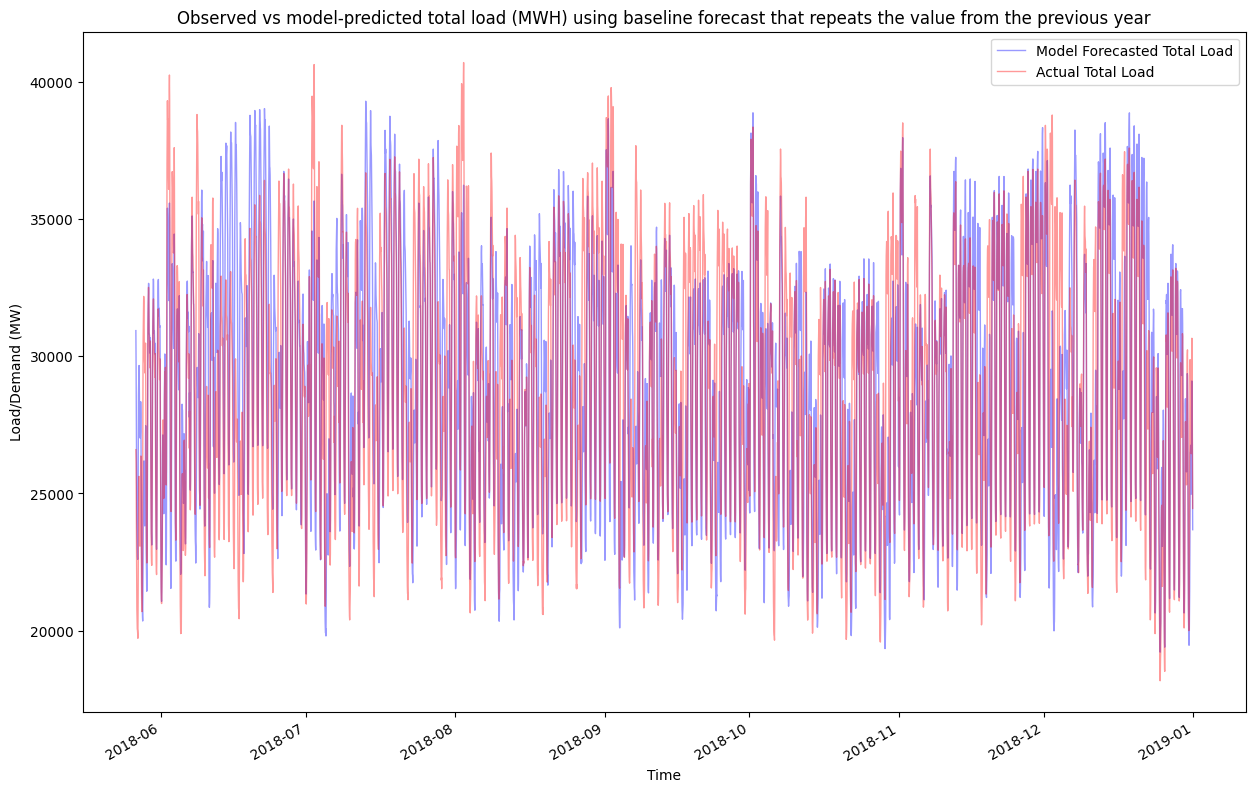

In [21]:
# plot y_pred and y-true for baseline year over year
plot_ts_pred_true(y_pred = df_features.loc[X_test.index.shift(-8760, freq='H'), 'total load actual'], y_true = y_test, 
                  model_name = "baseline forecast that repeats the value from the previous year")

Visually we can can see that the baseline model that just uses the value from the same time from the previous year does a decent job, but misses is off pretty badly sometimes. Which makes sense, because on average things are similar year to year but the peak demand will definitely be much higher or much lower on certain days. Let's try out a couple more regression models before trying some time series forecasting:

### Random Forest

In [22]:
#set up a parameter grid of different values for GridSearchCV of number of trees and max depth
n_est = [int(n) for n in np.logspace(start=1, stop=2.5, num=12)]
max_depth = list(range(1,6))

param_grid = {
        'n_estimators': n_est,
        'max_depth': max_depth
}
param_grid

{'n_estimators': [10, 13, 18, 25, 35, 48, 65, 90, 123, 168, 231, 316],
 'max_depth': [1, 2, 3, 4, 5]}

In [23]:
#create instance of base model
rfreg = RandomForestRegressor()

#create TS splits for cross val (instead of random splits, this uses progressively larger sets starting from beginning)
tss = TimeSeriesSplit(n_splits=5)

#create instance of RandomSearchCV
rf_cv = RandomizedSearchCV(rfreg, param_distributions=param_grid, cv=tss, random_state=47)

# Fit the random search model using reduced feature space X set
rf_cv.fit(X_train_red, y_train)

rf_cv.best_params_


{'n_estimators': 13, 'max_depth': 5}

The R^2 score:

In [24]:
rf_cv.score(X_train_red, y_train)

0.27861892687461487

In [25]:
rf_cv.score(X_test_red, y_test)

0.25628975697935186

In [26]:
#RF error metrics
error_metrics(y_train, rf_cv.predict(X_train_red),  
                  model_name = 'Random Forest Regression on reduced feature space tuned with Random Search CV (train)')


Error metrics for model: Random Forest Regression on reduced feature space tuned with Random Search CV (train)
RMSE: 3882.06
Variance/R^2: 0.28
MAE: 3186.02
Mean Absolute Percentage Error: 11.49 %


Let's also try Random Forest on the full feature space dataset:

In [27]:
#create instance of base model
rfreg = RandomForestRegressor()

#create TS splits for cross val (instead of random splits, this uses progressively larger sets starting from beginning)
tss = TimeSeriesSplit(n_splits=5)

#create instance of RandomSearchCV
rf_cv_full = RandomizedSearchCV(rfreg, param_distributions=param_grid, cv=tss, random_state=47)

# Fit the random search model using reduced feature space X set
rf_cv_full.fit(X_train, y_train)

rf_cv_full.best_params_

{'n_estimators': 13, 'max_depth': 5}

In [28]:
rf_cv_full.score(X_train, y_train)

0.36943347831252893

In [29]:
rf_cv_full.score(X_test, y_test)

0.377761568423703

In [30]:
error_metrics(y_train, rf_cv_full.predict(X_train), 
                  model_name = 'Random Forest Regression tuned with Random Search CV (train)')


Error metrics for model: Random Forest Regression tuned with Random Search CV (train)
RMSE: 3629.49
Variance/R^2: 0.37
MAE: 2859.44
Mean Absolute Percentage Error: 10.23 %


In [31]:
error_metrics(y_test, rf_cv_full.predict(X_test), 
                  model_name = 'Random Forest Regression tuned with Random Search CV (test)')


Error metrics for model: Random Forest Regression tuned with Random Search CV (test)
RMSE: 3621.38
Variance/R^2: 0.38
MAE: 2850.34
Mean Absolute Percentage Error: 9.93 %


c:\Users\jamua\AppData\Local\Programs\Python\Python313\Lib\site-packages\pandas\plotting\_matplotlib\core.py:981: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  return ax.plot(*args, **kwds)


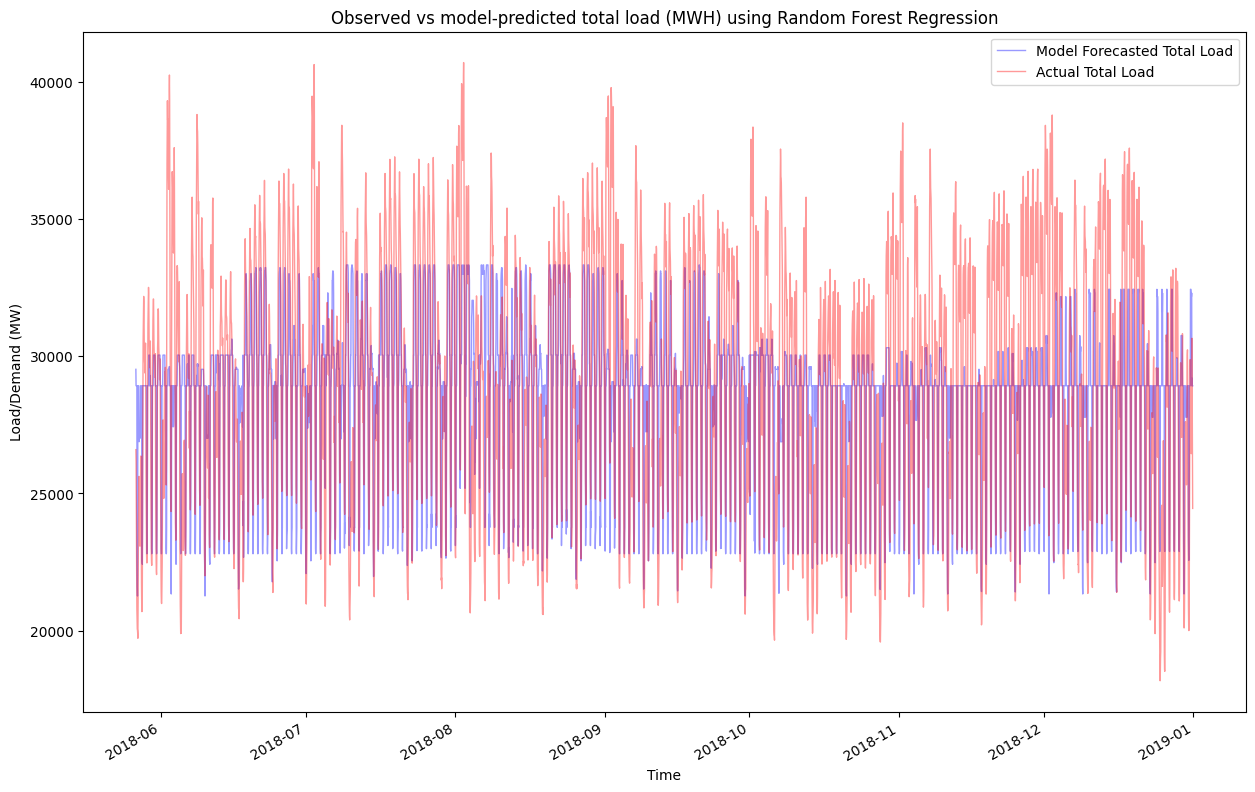

In [32]:
plot_ts_pred_true(y_pred = rf_cv_full.predict(X_test), y_true = y_test, model_name = "Random Forest Regression")

So Random Forest performs slightly worse that linear regression. It seems to consistently underpredict the true values. Let's also try KNeighbors Regression:
###  KNN

In [33]:
#set up a parameter grid for KNeighbors Random CV search:

n_neigh = [int(n) for n in np.logspace(start=0.5, stop=1.8, num=10)]
weights = ['uniform', 'distance']
leaf_size = [int(n) for n in np.logspace(start=0.5, stop=1.9, num=6)]

kn_param_grid = {
        'n_neighbors': n_neigh,
        'weights': weights,
        'leaf_size':leaf_size
}
kn_param_grid

{'n_neighbors': [3, 4, 6, 8, 11, 16, 23, 32, 45, 63],
 'weights': ['uniform', 'distance'],
 'leaf_size': [3, 6, 11, 21, 41, 79]}

In [34]:
#create instance of base model
kn = KNeighborsRegressor()

#create TS splits for cross val (instead of random splits, this uses progressively larger sets starting from beginning)
tss = TimeSeriesSplit(n_splits=5)

#create instance of RandomSearchCV
kn_cv = RandomizedSearchCV(kn, param_distributions = kn_param_grid, cv=tss, random_state=47)

# Fit the random search model using reduced feature space X set
kn_cv.fit(X_train, y_train)

kn_cv.best_params_


{'weights': 'distance', 'n_neighbors': 11, 'leaf_size': 41}

In [35]:
kn_cv.score(X_train, y_train)

0.9999999999999905

In [36]:
kn_cv.score(X_test, y_test)

0.5324938320536705

In [37]:
error_metrics(y_test, kn_cv.predict(X_test), 
                  model_name = 'KNN tuned with Random Search CV (test)')


Error metrics for model: KNN tuned with Random Search CV (test)
RMSE: 3138.99
Variance/R^2: 0.53
MAE: 2322.34
Mean Absolute Percentage Error: 7.89 %


c:\Users\jamua\AppData\Local\Programs\Python\Python313\Lib\site-packages\pandas\plotting\_matplotlib\core.py:981: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  return ax.plot(*args, **kwds)


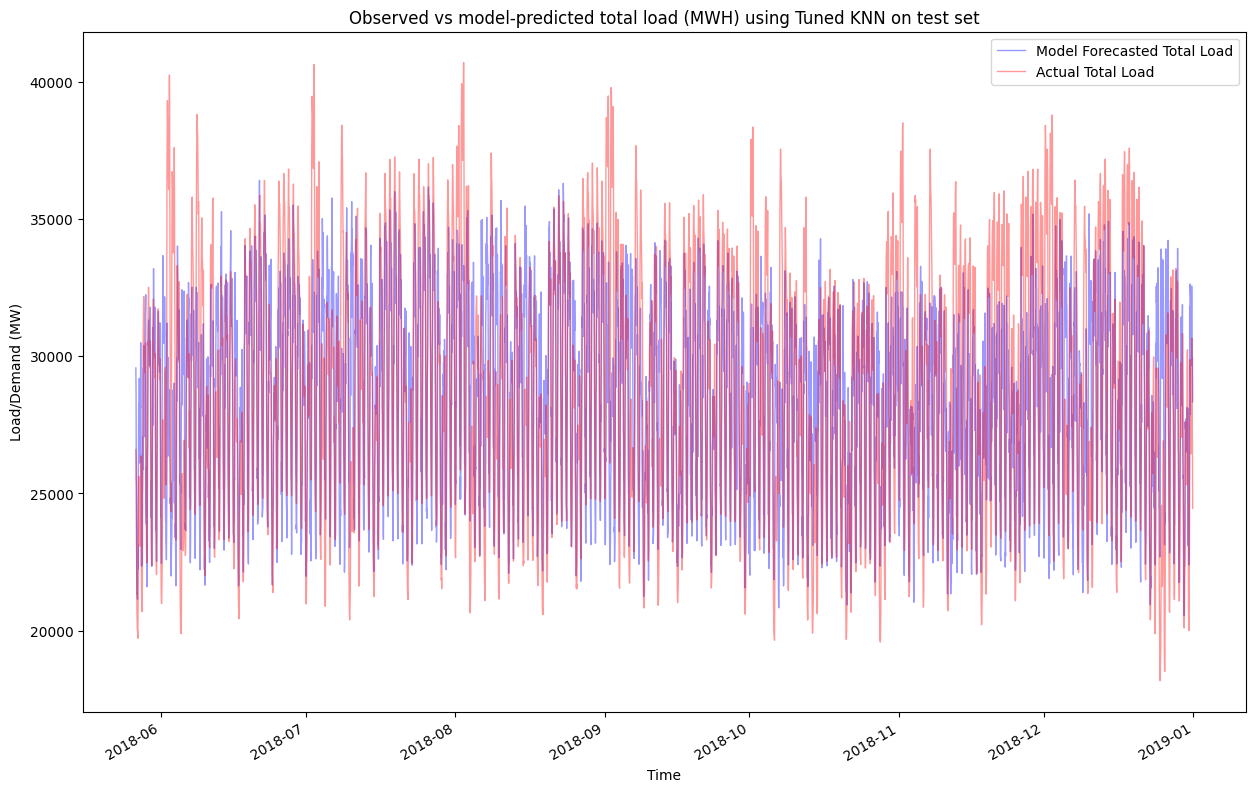

In [38]:
plot_ts_pred_true(y_pred = kn_cv.predict(X_test), y_true = y_test, model_name = "Tuned KNN on test set")

As expected, this model wildly overfits the training data and performs similarly to Random Forest and linear regression on the test data. Now to try some time series forecasting.

## XGBoost

One other model to try would be Extreme Gradient Boosting (or XGBoost) which is very good at finding patterns in data and often provides better results than other ML algorithms. XGBoost can do a decent job with time series forecasting where there is seasonality but not much trend, as it cannot extrapolate. Since this dataset essentially has no trend, it may perform well.

In [39]:
from xgboost import XGBRegressor

In [40]:
#set up a parameter grid for hyperparameter Random CV search:

n_est = [int(n) for n in np.logspace(start=1, stop=2.5, num=10)]
max_depth = [0,3,6,9]
learn_rate = [0.1,0.2,0.3,0.4,0.5]

xgb_param_grid = {
        'n_estimators': n_est,
        'max_depth': max_depth,
        'learning_rate':learn_rate
}
xgb_param_grid

{'n_estimators': [10, 14, 21, 31, 46, 68, 100, 146, 215, 316],
 'max_depth': [0, 3, 6, 9],
 'learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5]}

In [41]:
#create XGB model instance
xgb_model = XGBRegressor()

#create TS splits for cross val (instead of random splits, this uses progressively larger sets starting from beginning)
tss = TimeSeriesSplit(n_splits=5)

#create instance of RandomSearchCV
xgb_cv = RandomizedSearchCV(xgb_model, param_distributions=xgb_param_grid, scoring='neg_root_mean_squared_error', cv=tss, random_state=47)

# Fit the random search model using reduced feature space X set
xgb_cv.fit(X_train, y_train)

xgb_cv.best_params_

{'n_estimators': 215, 'max_depth': 3, 'learning_rate': 0.4}

In [42]:
# calculate the RMSE of the model on the train set using the tuned hyperparameters
# best_params = {'n_estimators': 215, 'max_depth': 3, 'learning_rate': 0.4}
best_RMSE = xgb_cv.best_score_
print(-best_RMSE)

2916.5566213635325


In [43]:
# predict on the test set
xgb_pred = xgb_cv.predict(X_test)

In [44]:
#calculate error metrics on train data
error_metrics(y_true = y_train, y_pred = xgb_cv.predict(X_train), 
              model_name = "XGBoost with weather data and engineered time-based features (train)")


Error metrics for model: XGBoost with weather data and engineered time-based features (train)
RMSE: 2546.73
Variance/R^2: 0.69
MAE: 1878.35
Mean Absolute Percentage Error: 6.71 %


c:\Users\jamua\AppData\Local\Programs\Python\Python313\Lib\site-packages\pandas\plotting\_matplotlib\core.py:981: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  return ax.plot(*args, **kwds)


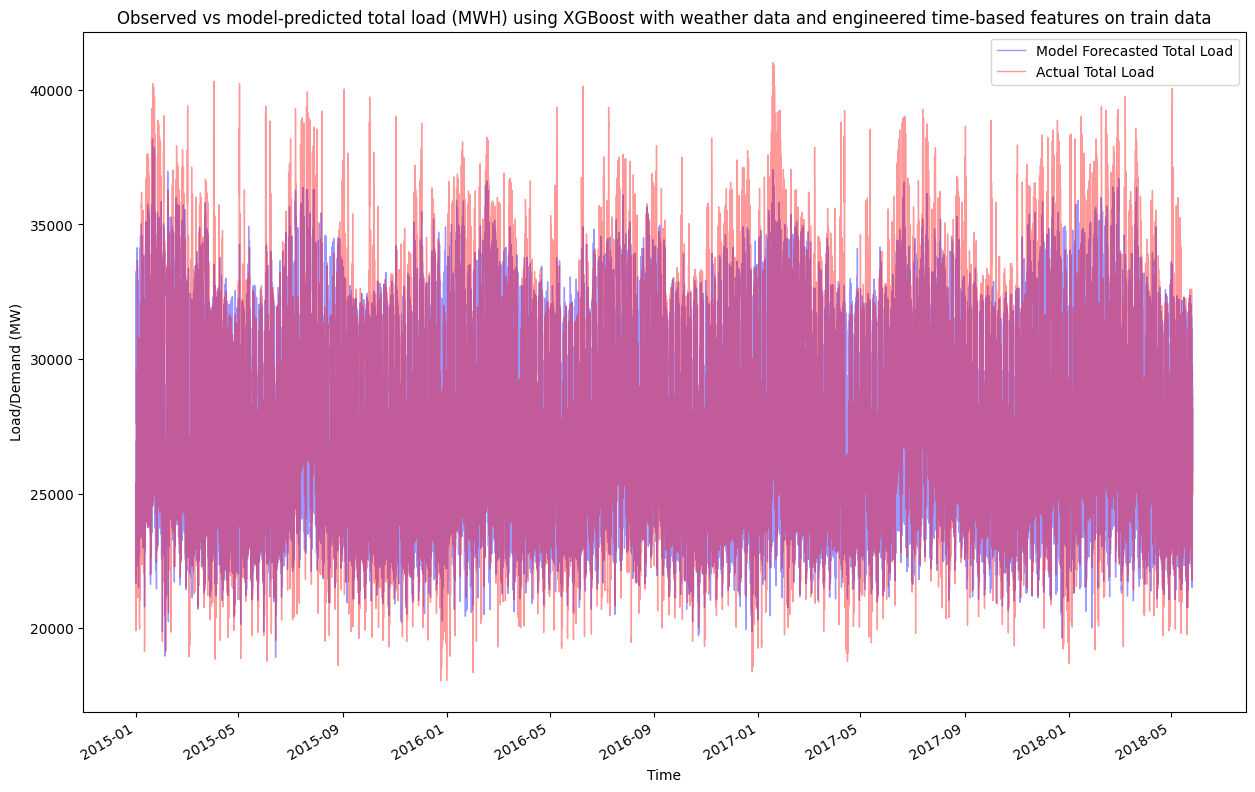

In [45]:
# plot the y_pred and y_true for train set
plot_ts_pred_true(y_pred = xgb_cv.predict(X_train), y_true = y_train, 
                  model_name = "XGBoost with weather data and engineered time-based features on train data")

In [46]:
#calculate error metrics on test data
error_metrics(y_true = y_test, y_pred = xgb_pred, 
              model_name = "XGBoost with weather data and engineered time-based features (test)")


Error metrics for model: XGBoost with weather data and engineered time-based features (test)
RMSE: 2798.04
Variance/R^2: 0.63
MAE: 2057.73
Mean Absolute Percentage Error: 7.05 %


c:\Users\jamua\AppData\Local\Programs\Python\Python313\Lib\site-packages\pandas\plotting\_matplotlib\core.py:981: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  return ax.plot(*args, **kwds)


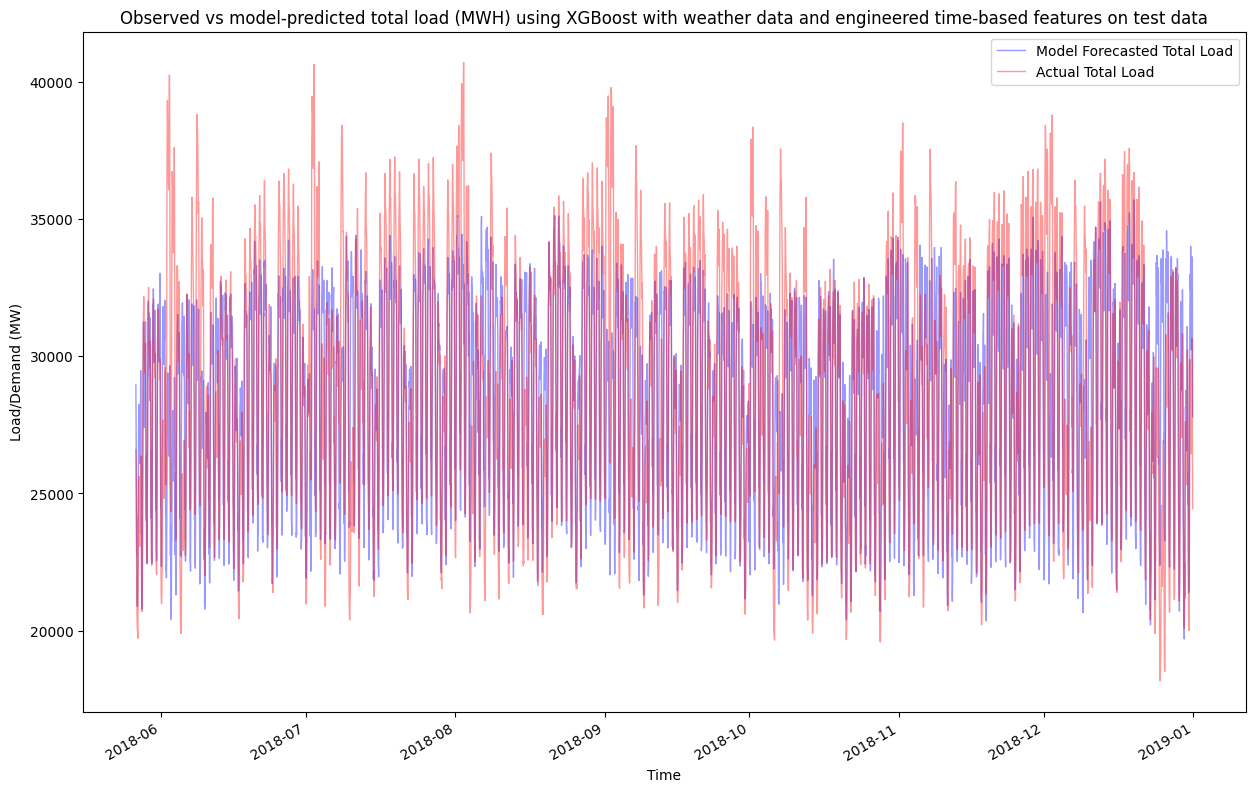

In [47]:
# plot the y_pred and y_true for test set
plot_ts_pred_true(y_pred = xgb_pred, y_true = y_test, 
                  model_name = "XGBoost with weather data and engineered time-based features on test data")

# Conclusions
Multiple models and variations on them were used to forecast the total energy demand in Spain (in MWH) using hourly load and weather data. The demand is highly dependent on temperature as well as time of day and day of week. As a time series, it exhibits daily, weely, and yearly seasonalities, but does not display much of a trend. Below is a compilation of the various models and their error metrics on training and test data.

In [48]:
#after running the error metric function on each model, the error_dict is populated w/ metrics for each
error_df = pd.DataFrame.from_dict(error_dict)

# create table and sort based on lowest RMSE
sorted_errors = np.round(error_df.pivot_table(index='Model Name', aggfunc='min').sort_values('RMSE', ascending=True),2)
sorted_errors

,MAE,MAPE,R2,RMSE
Model Name,,,,
XGBoost with weather data and engineered time-based features (train),1878.35,6.71,0.69,2546.73
XGBoost with weather data and engineered time-based features (test),2057.73,7.05,0.63,2798.04
simple linear regression (test),2174.62,7.55,0.36,2850.09
simple linear regression (train),2202.80,7.64,0.36,2860.88
Baseline forecast (repeat of previous year) (test),2249.00,NaN,0.54,3100.81
KNN tuned with Random Search CV (test),2322.34,7.89,0.53,3138.99
Random Forest Regression tuned with Random Search CV (test),2850.34,9.93,0.38,3621.38
Random Forest Regression tuned with Random Search CV (train),2859.44,10.23,0.37,3629.49
Random Forest Regression on reduced feature space tuned with Random Search CV (train),3186.02,11.49,0.28,3882.06


### Take Home: 
Based on RMSE, Prophet barely edges out XGBoost in terms of performance on the 7-month forecast of total energy demand, based on 41 months of training data. Prophet performs similarly to SARIMAX days into the forecast window, and with considerably lower training time. But since the SARIMA does so well on the training data, it may be useful on very short forecast windows, one to several hours into the future. Both have a place, as accurate long term forecasts are important for general planning and overall energy generation mix strategy, while hour-ahead (to several hours ahead) forecasts are critical for firing on fast-to-ramp-up systems for meeting peak demands.

### Further Investigation
Future efforts with this dataset could compare Prophet and/or XGBoost to the Spanish system operator's prediction of the total load. It would also be interesting to predict the contribution of wind generated energy given the wind speed and total load.

PEAK DEMAND PER CITY

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder


In [50]:
# Load data
df = pd.read_csv('combined_avg.csv', index_col='time', parse_dates=True)

# Ensure dataset has necessary columns
required_cols = ['city', 'total load actual']
if not all(col in df.columns for col in required_cols):
    raise ValueError("Dataset must contain 'city' and 'total load actual' columns.")

# Extract date-related features
df['date'] = df.index.date
df['hour'] = df.index.hour
df['weekday'] = df.index.weekday
df['month'] = df.index.month

# Compute daily peak demand per city
peak_demand = df.groupby(['city', 'date'])['total load actual'].max().reset_index()


In [51]:
# Encode city column
label_encoder = LabelEncoder()
peak_demand['city_encoded'] = label_encoder.fit_transform(peak_demand['city'])

# Drop original city column
peak_demand.drop(columns=['city'], inplace=True)

# Create lag features (past demand)
for lag in range(1, 15):  # Try 14-day history
    peak_demand[f'lag_{lag}'] = peak_demand['total load actual'].shift(lag)

# Rolling Mean Features (Smooth Fluctuations)
peak_demand['rolling_7'] = peak_demand['total load actual'].rolling(7).mean()
peak_demand['rolling_14'] = peak_demand['total load actual'].rolling(14).mean()

# Drop NaN values
peak_demand.dropna(inplace=True)


In [52]:
# Feature & Target Split
X = peak_demand.drop(columns=['total load actual', 'date'])
y = peak_demand['total load actual']

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=False)
# Hyperparameter Tuning for XGBoost
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.05, 0.1, 0.2],
    'subsample': [0.8, 1.0],
}

model = XGBRegressor(random_state=42)
grid_search = GridSearchCV(model, param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best Model from Grid Search
best_model = grid_search.best_estimator_

# Predict
y_pred = best_model.predict(X_test)

# Evaluate Model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Optimized RMSE: {rmse}")
print(f"Optimized R² Score: {r2}")

Optimized RMSE: 1225.5138998192176
Optimized R² Score: 0.8721600910665739


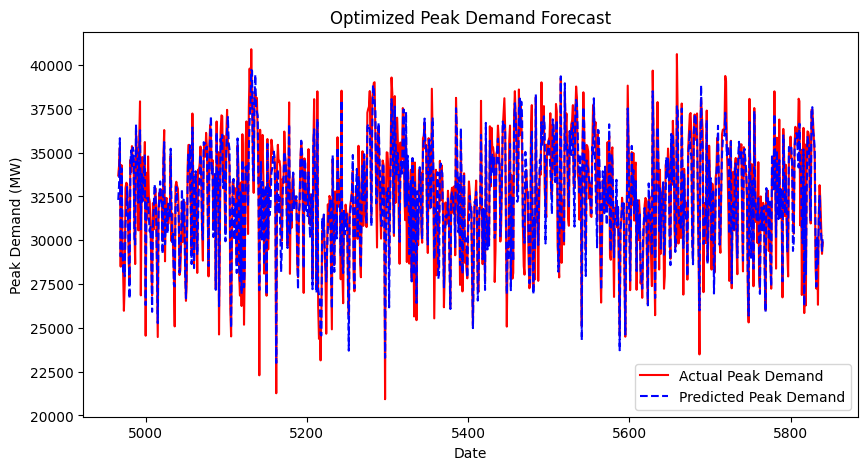

In [53]:

# Plot Actual vs Predicted Peak Demand
plt.figure(figsize=(10, 5))
plt.plot(y_test.index, y_test, label='Actual Peak Demand', color='red')
plt.plot(y_test.index, y_pred, label='Predicted Peak Demand', linestyle='dashed', color='blue')
plt.title("Optimized Peak Demand Forecast")
plt.xlabel("Date")
plt.ylabel("Peak Demand (MW)")
plt.legend()
plt.show()
